# Assignment 1: Automatic Detection of Social Media Bots

*Can you write a model to detect if a tweet was written by a real person or generated by AI?*

Recent improvements in language modelling have made it possible for machines to generate text that looks very human-like. In 2019, OpenAI introduced GPT-2, a model that can create coherent and convincing text on its own. Since then, even better models have been developed. Unfortunately, bad actors could misuse these powerful tools to create fake messages, spreading misinformation online.

In fact, it seems that [we humans are pretty vulnerable to AI-generated text](https://www.businessinsider.com/ai-generated-tweets-study-openai-gpt3-misinformation-2023-6):

![Your Image Description](https://i.ibb.co/rF9XXVd/fake-text-nlp.png)



The problem of detecting AI-generated content has become a hot topic. For instance, both Bill Gates (Microsoft) and Mark Zuckerberg (Facebook) recently organized a competition offering $110,000 in cash prizes for models capable of identifying AI-generated text. [Here is the link to the competition, if you are curious](https://www.kaggle.com/competitions/llm-detect-ai-generated-text).

Your job in this assignment is to build models that can detect machine-generated text on Twitter ("fake tweets"). Specifically, you will develop **text classifiers** that can determine whether a tweet was written by a human (label “human”) or a language model (label “bot”).

You will implement classifiers based on some of the methods we saw in class: Logistic Regression and Neural Networks.

To train the models, you'll have access to a dataset of real deepfake tweets, TweepFake. It is real in the sense that each deepfake tweet was actually posted on Twitter. The collected tweets come from a total of 23 bots, imitating 17 human accounts. The bots are based on various generation techniques, i.e., Markov Chains, RNN, RNN+Markov, LSTM, GPT-2.The dataset also includes randomly selected tweets from the humans imitated by the bots to have an overall balanced dataset of 25,572 tweets (half human and half bots generated).

Let's start with some useful imports.



In [ ]:
from typing import Tuple, List, Dict, Any

import pandas as pd
import random
import re

import matplotlib.pyplot as plt
from gensim.models.keyedvectors import load_word2vec_format

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
SEED = 2222

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# 1 Input representation: pretrained word embeddings

To process the tweet inputs and make predictions, your classifiers need a numerical representation of these inputs. In this assignment, you'll use word embeddings to represent the words in the input tweets. We are going to use embeddings from the **word2vec** Google News pretrained model. This is an embedding model that contains 300-dimensional vectors for 3 million words and phrases.

We're providing a download link here to the pretrained word embeddings, so you can easily start working with them:

In [3]:
#import gdown
#import zipfile

# Google Drive direct download link
#url = 'https://drive.google.com/uc?id=1zQRH1zYBHJ_vU_uMkKvvvwQiZwP5N7wW'

# Destination file name
#output = 'NLP_DATA.zip'

# Download the file
#gdown.download(url, output, quiet=False)

# Unzip the downloaded file
#with zipfile.ZipFile(output, 'r') as zip_ref:
 #    zip_ref.extractall('.')

In [4]:
# Download the file using wget
#!wget 'https://drive.google.com/uc?id=1zQRH1zYBHJ_vU_uMkKvvvwQiZwP5N7wW' -O NLP_DATA.zip

# Unzip the downloaded file using unzip
#!unzip NLP_DATA.zip

You should now have a folder called `NLP_Data`. It contains pretrained embeddings in the `embeddings` subfolder, and data for training, validation and testing, in the `data` subfolder.

Let's load the pretrained model into the variable `w2v_model`. It will take a few moments to be ready.

In [6]:
# Load embeddings model to use in the assignment
w2v_model = load_word2vec_format("NLP_Data/embeddings/GoogleNews-vectors-negative300.bin.gz", binary = True)

# 2 Playing with embeddings

This section has the objective to familiarize yourself with the embeddings of the word2vec model. word2vec is not a singular algorithm, rather, it is a family of model architectures and optimizations that can be used to learn word embeddings from large datasets. Embeddings learned through word2vec have proven to be successful on a variety of downstream natural language processing tasks.

As we said, we are going to work with a word2vec Google News  pretrained model. Let's play with this model. You have a tutorial [here](https://archive.is/20231103133039/https://www.analyticsvidhya.com/blog/2023/07/step-by-step-guide-to-word2vec-with-gensim/#selection-2077.0-2077.18) if you get stuck in some steps. Check out the "Exploring the Model" section to see how you can access information about specific embeddings.

- What is the dimension of the embedding?

In [7]:
# TODO: Check vector_size of w2v_model to obtain embedding size
vector_size: int = w2v_model.vector_size
print(f"The vector size of w2v_model is: {vector_size}")

The vector size of w2v_model is: 300


- Your professors are obsessed with the word `banana`, so you must obtain the embedding of this word. Do not ask why. If you ask why your mark will be penalized.

In [8]:
# TODO: Obtain the embeddings of the word banana
banana_embedding = w2v_model["banana"]
print(banana_embedding)

[-8.54492188e-02  4.71191406e-02 -6.93359375e-02  3.02734375e-01
 -1.87500000e-01 -3.19824219e-02  2.95410156e-02 -2.05078125e-01
 -9.03320312e-02  2.98828125e-01  2.10937500e-01 -6.88476562e-02
  4.76074219e-02  5.83496094e-02 -2.75390625e-01  2.42187500e-01
 -3.22265625e-01  4.73632812e-02 -1.44531250e-01  9.37500000e-02
  6.74438477e-03  2.17773438e-01  2.31445312e-01  1.87500000e-01
  8.49609375e-02 -5.39550781e-02 -2.65625000e-01  2.23388672e-02
  2.24609375e-01  4.12109375e-01 -2.30712891e-02 -1.67968750e-01
  1.01928711e-02  2.10937500e-01  1.14135742e-02  2.50000000e-01
  8.64257812e-02 -2.16796875e-01  8.93554688e-02  1.50390625e-01
 -2.03125000e-01 -2.30468750e-01  1.42578125e-01  1.34765625e-01
 -1.13769531e-01 -1.80664062e-01  3.58886719e-02 -1.69921875e-01
  1.55273438e-01  2.39257812e-01 -2.30468750e-01 -9.96093750e-02
  1.82617188e-01 -1.81640625e-01 -1.46484375e-01 -7.03125000e-02
  9.37500000e-02 -2.67578125e-01  2.17285156e-02 -1.45507812e-01
 -2.38037109e-02  1.53320

- Sadly, there is no `banana` in the teacher's lounge, but your professors want to know if there exists any similar words that might be in the lounge. Use the `most_similar()` method from the model to obtain the 15 most similar words.

In [ ]:
# TODO: Obtain most similar words of banana
similar_words_banana: List[tuple[str,float]] = w2v_model.most_similar("banana", topn=15)
print(similar_words_banana)

[('bananas', 0.7523775696754456), ('pineapple', 0.6587537527084351), ('mango', 0.6365212202072144), ('pineapples', 0.6313879489898682), ('papaya', 0.6063666343688965), ('coconut', 0.6035483479499817), ('potato', 0.5747568011283875), ('melon', 0.5625775456428528), ('cashew', 0.562165379524231), ('tomato', 0.5590206384658813), ('Cavendish_bananas', 0.5539610385894775), ('sago', 0.5539475679397583), ('Banana', 0.5530382394790649), ('pineapples_bananas', 0.5497475862503052), ('mangoes', 0.5473405122756958)]


- We do not like any of the previous words, how similar is the `banana` word to the `cake` word according to the model?

In [10]:
# TODO: Obtain similarity between banana and cake
similarity_banana_cake: float = w2v_model.similarity("banana", "cake")
print("Similarity between banana and cake is: ",similarity_banana_cake)

Similarity between banana and cake is:  0.3261957


Now that we decided on the dessert and the model has told us that `cake` is the correct answer because is 32.6% similar to eating a `banana`. Because 0.326 is a huge similarity. Do not check the similarity between, for example, `tremendous` and `negligible`.

In [11]:
# TODO: Obtain similarity between tremendous and negligible
similarity_tremendous_negligible: float = w2v_model.similarity("tremendous", "negligible")
print("Similarity between tremendous and negligible is: ",similarity_tremendous_negligible)

Similarity between tremendous and negligible is:  0.37869066


Okay, `banana` and `cake` are not as similar as we want them to be.

- Could you give me the most dissimilar words to `banana`? You can use the `negative` argument in the `most_similar()` method.

In [ ]:
# TODO: Obtain least similar words of banana
less_similar_words_banana: List[tuple[str,float]] = w2v_model.most_similar(negative=["banana"])
print(less_similar_words_banana)

[('NORWALK_CONN', 0.2376854419708252), ('JIM_HANNON_TimesDaily', 0.2376764565706253), ('KITCHENER_ONTARIO', 0.23705120384693146), ('DENVER_CO_PRWEB', 0.23474794626235962), ('GRANDE_BAY_MAURITIUS', 0.23164312541484833), ('Dr._Parviz_Azar', 0.22826240956783295), ('HuMax_IL8_TM', 0.22697211802005768), ('subsidiary_Airstar', 0.22571398317813873), ('AB_OMX_Stockholm', 0.22488577663898468), ('MotoTron_electronic_controls', 0.22116823494434357)]


Okey, that was severely uninformative. Let's move on.

Now that we all agree that `cake` is very similar to eating a fruit, let's decide which ingredients to add to the `pizza` we are going to eat without you. Because we are professors. And you are students. You may not have pizza nor cake.

We all know that a good `pizza` should have `tomato_sauce` (pizza bianca is not pizza, is garlic bread) and `cheese` (marinara does not count). However, Andrés defends the idea of swedish favourite [banana curry pizza](https://andmykitchensink.com/banana-curry-pizza-a-swedish-favorite/) being the best pizza.

- Let's check if `banana` match with the `['pizza', 'tomato_sauce', 'cheese']` ingredients. Use the `doesnt_match()` method of the word2vec model.

In [161]:
# TODO: Use the doesnt_match method to detect the unlikely word
word: str = w2v_model.doesnt_match(["pizza", "tomato_sauce", "cheese", "banana"])
print(f"Word: {word}")

Word: banana


See Andrés, even AI does not like your banana pizza.

Now, to answer the question which word is to woman as king is to man, you will use:

```
w2v_model.most_similar(positive=["woman", "king"], negative=["man"], topn=3)
```
- Which word is to `professor` as `harry_potter` is to `student`?


In [14]:
# TODO: Obtain which words is to professor as harry potter is to student
w2v_model.most_similar(positive=["professor", "harry_potter"], negative=["student"], topn=3)

[('deathly_hallows', 0.49967706203460693),
 ('movi', 0.44809484481811523),
 ('miley_cyrus', 0.43784138560295105)]

*Snape entering the potion's laboratory:

🎵🎶 And I came in like a wreeeecking baaaaaaall 🎵🎶


Have you ever wondered how would be your name if you were of the opposite genre?
For me, this can be done using:


```
w2v_model.most_similar(positive=["Jaime", "she"], negative=["he"], topn=3)
```

- Create the command to obtain your opposite gender name. It may not work if your name does not appear in the model vocabulary.

In [165]:
# TODO: Create the command to obtain your opposite gender name
w2v_model.most_similar(positive=["Raquel", "he"], negative=["she"], topn=3)

[('Antonio', 0.632328450679779),
 ('Sergio', 0.6318668723106384),
 ('Gustavo', 0.6197564005851746)]

# 3 Preprocessing the data and loading it

Now that you feel familiar with how the word2vec model works, let's create some functions that would be in charge of the preprocessing of the data. You are free to perform any operation you feel right to preprocess the data.


## 3.1. Tweet tokenization

Let's start with some form of **tokenization** on the tweets. That is, write a tokenizer that, given tweet, splitting the text into words, and performs any text normalization you find suitable.

For this, we suggest that you define a function `tokenize_tweet` which takes a sentence as a string, and returns the tokenized sentence.


In [ ]:
def tokenize_tweet(tweet: str) -> list[str]:
    """
    Tokenizes a given tweet by splitting the text into words, and doing any cleaning, replacing or normalization deemed useful

    Args:
        tweet (str): The tweet text to be tokenized.

    Returns:
        list[str]: A list of strings, representing the tokenized components of the tweet.
    """
    # TODO: Complete the tokenize_tweet function

    tweet: str = re.sub(r"@\w+", "@user", tweet)
    tweet: str = re.sub(r"http\S+|www\S+|https\S+", "url", tweet)
    tweet: str = re.sub(r"#\w+", "", tweet)
    tweet: str = re.sub(r"\s+", " ", tweet).strip()
    tokens: list[str] = tweet.split()

    return tokens


Here's an example of how this may work.

In [104]:
tokenize_tweet("I think you should NOT run for president @obama https://gop.com #trumpforpresident #maga")

['I',
 'think',
 'you',
 'should',
 'NOT',
 'run',
 'for',
 'president',
 '@user',
 'url']

You should choose your own tokenization strategy. You may remove hashtags, disregard words that do not have associated word2vec embeddings, etc.

Here's a baseline tokenization idea, but you may want to think of something more effective/tailored to this classification task.

1. User mentions are replaced with a specific token.
2. URLs are replaced with a specific token.
3. Hashtags are removed.

## 3.2. Load data for training, validation and test dataset

Next, you'll need to load the data, which is placed in the `data` subfolder.

Write a `load_data` function that takes a path to one of the data files, such as `/content/NLP_Data/data/train.csv`.

Calling load data with that file path should return the tokenized texts and their corresponding labels. Here's how it may look:

 ```

 tr_texts, tr_targets = load_data('/content/NLP_Data/data/train.csv')

 # Checking the first training text and label

print(tr_texts[0], tr_targets[0])

['YEA', 'now', 'that', 'note', 'GOOD'], 1


 ```

You should end up with a training set that looks like the following. Change the code below if needed, to fit your data loading function, but do include a DataFrame to visualize the loaded data.

In [ ]:
def load_data(file_path: str) -> Tuple[List[List[str]], List[int]]:
    """
    Load data from a specified file path, extract texts and targets, and tokenize the texts using the tokenize_tweet function.

    Parameters:
    file_path (str): The path to the dataset file.

    Returns:
    Tuple[List[str], List[int]]: Lists of texts and corresponding targets.
    """
    try:
        data: pd.DataFrame = pd.read_csv(file_path) # TODO: Read the corresponding csv
        data: pd.DataFrame = data.drop(columns=["screen_name", "class_type"]).rename(columns={"text": "Tweets", "account.type": "Labels"})

        texts: List[str] = [tokenize_tweet(text) for text in data["Tweets"].astype(str)] # TODO: Obtain the text column from data
        targets: List[int] = data["Labels"].apply(lambda x: 1 if x == "bot" else 0).astype(int).tolist() # TODO: Obtain targets, 0 for human and 1 for bot
        return texts, targets # TODO: Return tokenized texts, and targets
    except FileNotFoundError:
        print(f"{file_path} not found. Please check the file path.")


In [106]:
# Load datasets
tr_texts, tr_targets = load_data('NLP_Data/data/train.csv')
vl_texts, vl_targets = load_data('NLP_Data/data/validation.csv')
ts_texts, ts_targets = load_data('NLP_Data/data/test.csv')

In [ ]:
import pandas as pd
training_data: pd.DataFrame = pd.DataFrame({'Tweets': tr_texts, 'Labels': tr_targets})
training_data[:4]

,Tweets,Labels
0,"[YEA, now, that, note, GOOD]",1
1,"[Listen, to, This, Charming, Man, by, The, Smi...",0
2,"[wish, i, can, i, would, be, seeing, other, ho...",1
3,"[The, decade, in, the, significantly, easier, ...",1


- What is the length of the longest tweet in the training dataset? and of the shortest?

In [108]:
# TODO: Your code goes here
max_length: int = max(len(tweet) for tweet in tr_texts)
min_length: int = min(len(tweet) for tweet in tr_texts)
print(f"Longest tweet: {max_length}")
print(f"Shortest tweet: {min_length}")

Longest tweet: 65
Shortest tweet: 0


## 3.3 Preparing dataset

Next, put your inputs and targets into a PyTorch `Dataset` object, which we'll use for training.

Define a `Dataset` class called `TweepFakeDataset(Dataset)`, which takes the tokenized tweets and labels, that we will later pass to a `DataLoader`.

In [109]:
class TweepFakeDataset(Dataset):
    """
    A PyTorch Dataset for the TweepFake dataset.

    Attributes:
        texts (List[List[str]]): List of tweets tokens.
        targets (List[str]): List of target labels.
    """

    def __init__(self,
                 texts: List[List[str]],
                 targets: List[int]
                 ):
        """
        Initializes the TweepFakeDataset with the given file path.

        Args:
            texts (List[List[str]]): List of tweets tokens.
            targets (List[str]): List of target labels.
        """
        # TODO: Complete the init function
        self.texts = texts
        self.targets = targets

    def __len__(self) -> int:
        """Returns the length of the dataset."""
        # TODO: Complete the len function
        return len(self.texts)

    def __getitem__(self, idx: int) -> Tuple[List[List[str]], List[int]]:
        """
        Returns the embedded tensor and target for the text at the specified index.

        Args:
            idx (int): Index of the item.

        Returns:
            Tuple[List[str], List[int]]: A tuple containing the texts and the target label for idx.
        """
        # TODO: Complete the getitem function
        text: str = self.texts[idx]
        target: int = self.targets[idx]
        return text, target

In [110]:
# TODO: Create datasets for models
tr_dataset = TweepFakeDataset(tr_texts,tr_targets)
vl_dataset = TweepFakeDataset(vl_texts,vl_targets)
ts_dataset = TweepFakeDataset(ts_texts,ts_targets)

## 3.4 Auxiliary functions

In this section, you'll prepare a few auxiliary function which we'll be used for training.

In [111]:
def word2idx(embedding_model: Any, tweet: List[str]) -> torch.Tensor:
    """
    Converts a tweet to a list of word indices based on an embedding model.

    This function iterates through each word in the tweet and retrieves its corresponding index
    from the embedding model's vocabulary. If a word is not present in the model's vocabulary,
    it is skipped.

    Args:
        embedding_model (Any): The embedding model with a 'key_to_index' attribute, which maps words to their indices.
        tweet (List[str]): A list of words representing the tweet.

    Returns:
        torch.Tensor: A tensor of word indices corresponding to the words in the tweet.
    """
    # TODO: Complete the function according to the requirements
    return torch.tensor([embedding_model.key_to_index[word] for word in tweet if word in embedding_model.key_to_index])

For the following function, you might want to check the [pad_sequence](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_sequence.html) function.

In [112]:
def collate_fn(batch: List[Tuple[List[str], int]]) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Prepares and returns a batch for training/testing in a torch model.

    This function sorts the batch by the length of the text sequences in descending order,
    tokenizes the text using a pre-defined word-to-index mapping, pads the sequences to have
    uniform length, and converts labels to tensor.

    Args:
        batch (List[Tuple[List[str], int]]): A list of tuples, where each tuple contains a
                                             list of words (representing a text) and an integer label.

    Returns:
        Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: A tuple containing three elements:
            - texts_padded (torch.Tensor): A tensor of padded word indices of the text.
            - labels (torch.Tensor): A tensor of labels.
            - lengths (torch.Tensor): A tensor representing the lengths of each text sequence.
    """
    # TODO: Sort the batch by the length of text sequences in descending order
    batch = sorted(batch, key=lambda x: len(x[0]), reverse=True)

    # TODO: Unzip texts and labels from the sorted batch
    texts, labels = zip(*batch)

    # TODO: Convert texts to indices using the word2idx function and w2v_model
    texts_indx: List[torch.Tensor] = [word_tensor for text in texts if (word_tensor := word2idx(w2v_model, text)).nelement() > 0]

    # TODO: Calculate the lengths of each element of texts_indx.
    # The minimum length shall be 1, in order to avoid later problems when training the RNN
    lengths: List[torch.Tensor] = torch.tensor([max(1, len(text)) for text in texts_indx], dtype=torch.long)

    # TODO: Pad the text sequences to have uniform length
    texts_padded: torch.Tensor = pad_sequence(texts_indx, batch_first=True,padding_value=0)

    # TODO: Convert labels to tensor
    labels: torch.Tensor = torch.tensor(labels, dtype=torch.int)

    return texts_padded, labels[:len(texts_indx)], lengths[:len(texts_indx)]

In [ ]:
def calculate_accuracy(model: torch.nn.Module, dataloader: DataLoader, threshold: float = 0.5, device: str = 'cpu') -> float:
    """
    Calculate the accuracy of a PyTorch model given a DataLoader.

    The function moves the model to the specified device, sets it to evaluation mode, and computes
    the accuracy by comparing the model's predictions against the true labels. The predictions are
    determined based on a specified threshold.

    Args:
        model (torch.nn.Module): The PyTorch model to evaluate.
        dataloader (DataLoader): The DataLoader containing the dataset to evaluate against.
        threshold (float, optional): Probability threshold to predict a sample as positive. Defaults to 0.5.
        device (str, optional): Device to which the model and data are moved ('cpu' or 'cuda'). Defaults to 'cpu'.

    Returns:
        float: The accuracy of the model on the given dataset.
    """
    # TODO: Calculate accuracy of a model given a dataloade
    model.to(device)
    model.eval()

    total_correct: int = 0
    total_samples: int = 0

    with torch.no_grad():
        for features, labels, text_len in dataloader:
            features, labels, text_len = features.to(device), labels.to(device), text_len.to(device)
            outputs: torch.Tensor = model(features, text_len)
            predictions: torch.Tensor = (torch.sigmoid(outputs) > threshold).float()
            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)
    accuracy: float = total_correct / total_samples
    return accuracy

# 4 Train loop

It's time to define the training loop. You'll end up training three types of models, Logistic Regression, MLP classifier and RNN classifier. However, we want to use the same training loop function for all of them.

Let's define a function `train_torch_model` to do so.

In [ ]:
def train_torch_model(model: torch.nn.Module, train_dataloader: DataLoader,
                val_dataloader: DataLoader, criterion: nn.Module,
                optimizer: optim.Optimizer, epochs: int,
                print_every: int, patience: int,
                device: str = 'cpu') -> Tuple[Dict[int, float],Dict[int, float]]:
    """
    Train and validate the logistic regression model.

    Args:
        model (torch.nn.Module): An instance of the model to be trained.
        train_dataloader (DataLoader): DataLoader for the training dataset.
        val_dataloader (DataLoader): DataLoader for the validation dataset.
        learning_rate (float): The learning rate for the optimizer.
        criterion (nn.Module): Loss function to use for training.
        optimizer (optim.Optimizer): Optimizer to use for training.
        epochs (int): The number of epochs to train the model.
        print_every (int): Frequency of epochs to print training and validation loss.
        patience (int): The number of epochs to wait for improvement on the validation loss before stopping training early.
        device (str): device where to train the model.

    Returns:
        Tuple[Dict[int, float],Dict[int, float]]: Dictionary of accuracies at each `print_every` interval for the training and validation datasets.
    """
    # TODO: Initialize dictionaries to store training and validation accuracies
    train_accuracies: Dict[int, float] = {}
    val_accuracies: Dict[int, float] = {}

    # TODO: Initialize variables for Early Stopping
    best_loss: float = float('inf')
    epochs_no_improve: int = 0

    # TODO: Move the model to the specified device (CPU or GPU)
    model.to(device)

    # TODO: Implement the training loop over the specified number of epochs
    for epoch in range(epochs):
        # TODO: Set the model to training mode
        model.train()
        total_loss: float = 0.0
        correct_train: int = 0
        total_train: int = 0

        # TODO: Implement the loop for training over each batch in the training dataloader
        for features, labels, text_len in train_dataloader:
            pass
            # TODO: Move features and labels to the specified device
            features, labels, text_len = features.to(device), labels.to(device), text_len.to(device)

            # TODO: Clear the gradients
            optimizer.zero_grad()

            # TODO: Forward pass (compute the model output)
            outputs: torch.Tensor = model(features, text_len)

            # TODO: Compute the loss
            loss = criterion(outputs.float(), labels.float())

            # TODO: Backward pass (compute the gradients)
            loss.backward()

            # TODO: Update model parameters
            optimizer.step()

            # TODO: Accumulate the loss
            total_loss += loss.item()

            predictions: torch.Tensor = (outputs > 0).float()
            correct_train += (predictions == labels).sum().item()
            total_train += labels.size(0)


        # TODO: Implement the evaluation phase
        model.eval()
        val_loss: float = 0.0
        correct_val: int = 0
        total_val: int = 0

        with torch.no_grad():
            # TODO: Loop over the validation dataloader
            for features, labels, text_len in val_dataloader:
                pass
                # TODO: Move features and labels to the specified device
                features, labels, text_len = features.to(device), labels.to(device), text_len.to(device)

                # TODO: Forward pass (compute the model output)
                outputs: torch.Tensor = model(features, text_len)

                # TODO: Compute the loss
                loss = criterion(outputs.float(), labels.float())  

                # TODO: Accumulate validation loss
                val_loss += loss.item()

                predictions: torch.Tensor = (outputs > 0).float()

                correct_val += (predictions == labels).sum().item()
                total_val += labels.size(0)

        # TODO: Print training and validation results every 'print_every' epochs
        if epoch % print_every == 0 or epoch == epochs - 1:
            pass
            # TODO: Calculate training and validation accuracy
            avg_train_loss: float = total_loss / len(train_dataloader)
            train_accuracy: float = correct_train / total_train

            avg_val_loss: float = val_loss / len(val_dataloader)
            val_accuracy: float = correct_val / total_val

            # TODO: Store accuracies
            train_accuracies[epoch] = train_accuracy
            val_accuracies[epoch] = val_accuracy

            # TODO: Calculate and print average losses and accuracies
            print(f"Epoch {epoch + 1}/{epochs}")
            print(f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
            print(f"Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")
            print("-" * 50)
            print()

        # TODO: Implement Early Stopping
        if avg_val_loss < best_loss:
            best_loss: float = avg_val_loss
            epochs_no_improve: int = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

    return train_accuracies, val_accuracies

# 5 Models

All model will use the embeddings from the `word2vec` model as their first layer, to translate the indexes prepared by the `collate_fn` function to their corresponding embedding vectors. Therefore, the first thing we should do is to extract the embedding layer from the `vectors` attribute of the `word2vec` model.

In [120]:
# TODO: Obtain embedding weights
embedding_weights: torch.Tensor = torch.tensor(w2v_model.vectors)
embedding_weights.shape

torch.Size([3000000, 300])

## 5.1. Logistic regression and MLP models

### 5.1.1. Logistic regression: define the model

In [121]:
import torch.nn as nn

class LogisticRegression(nn.Module):
    """
    A Logistic Regression model implemented as a PyTorch neural network for text classification.

    This model uses pre-trained embeddings and applies mean pooling on the embeddings of the input text.
    It includes a dropout layer for regularization followed by a linear layer for classification.

    Attributes:
        embedding (nn.Embedding): An embedding layer initialized with pre-trained weights.
        fc (nn.Linear): A linear layer for classification.
        dropout (nn.Dropout): A dropout layer for regularization.

    Args:
        embedding_weights (torch.Tensor): Pre-trained word embeddings.
        dropout (float): Dropout rate for regularization.
    """

    def __init__(self, embedding_weights: torch.Tensor, dropout: float):
        """
        Initializes the LogisticRegression model with given embedding weights and dropout rate.

        Args:
            embedding_weights (torch.Tensor): The pre-trained embedding weights to be used in the embedding layer.
            dropout (float): The dropout rate to be used for regularization.
        """
        super().__init__()
        # TODO: Determine the embedding dimension from the embedding weights
        embedding_dim: int = embedding_weights.shape[1]

        # TODO: Create an embedding layer with the given pre-trained weights, use the Embedding.from_pretrained function
        self.embedding : nn.Embedding = nn.Embedding.from_pretrained(embedding_weights, freeze=True)

        # TODO: Create a linear layer for classification
        self.fc : nn.Linear = nn.Linear(embedding_dim, 1)

        # TODO: Create a dropout layer for regularization
        self.dropout : nn.Dropout = nn.Dropout(dropout)

    def forward(self, x, text_lengths):
        """
        Defines the forward pass of the LogisticRegression model.

        Args:
            x (torch.Tensor): Input tensor containing word indices.
            text_lengths (torch.Tensor): Tensor containing the lengths of texts in the batch.

        Returns:
            torch.Tensor: Output tensor after passing through the model.
        """
        # TODO: Embed the input text using the embedding layer
        embedded : torch.Tensor = self.embedding(x)

        # TODO: Apply mean pooling on the embeddings on the word dimension to obtain a embedded sentence
        mask: torch.Tensor = (x != 0).float().unsqueeze(-1)  
        embedded_sum: torch.Tensor = torch.sum(embedded * mask, dim=1) 
        embedded_sentence : torch.Tensor = embedded_sum / text_lengths.unsqueeze(1)

        # TODO: Apply dropout for regularization
        hidden : torch.Tensor = self.dropout(embedded_sentence)

        # TODO: Return the final output after passing it through the linear layer
        return self.fc(hidden).squeeze(1)


### 5.1.2. Logistic regression: load the data

In [122]:
# TODO: Define configuration for logistic regression training
batch_size: int = 64
epochs: int = 150
print_every: int = 2
patience: int = 15 
learning_rate: float = 0.001 # 0.01

# TODO: Check if GPU is available and move the model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# TODO: Create data loaders with specified batch_size, shuffle the training dataloader, and use collate_fn
logreg_train_dataloader: DataLoader = DataLoader(tr_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
logreg_val_dataloader: DataLoader = DataLoader(vl_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
logreg_test_dataloader: DataLoader = DataLoader(ts_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

In [124]:
# TODO: Instantiate the Logistic Regression model
logistic_model: LogisticRegression = LogisticRegression(embedding_weights, dropout=0.5).to(device)

In [ ]:
# TODO: Define suitable loss criterion and optimizer
logistic_criterion = torch.nn.BCEWithLogitsLoss()
logistic_optimizer: optim = optim.Adam(logistic_model.parameters(), lr=learning_rate, weight_decay=0.0001)

### 5.1.3. Logistic regression: train the model and plot the accuracies

In [128]:
# TODO: Train Logistic Regression model
log_train_accuracies, log_val_accuracies = train_torch_model(logistic_model, logreg_train_dataloader,
                                                             logreg_val_dataloader, logistic_criterion,
                                                             logistic_optimizer, epochs, print_every,
                                                             patience=patience, device=device)

Epoch 1/150
Train Loss: 0.6404, Val Loss: 0.6369
Train Accuracy: 0.6520, Val Accuracy: 0.6427
--------------------------------------------------

Epoch 3/150
Train Loss: 0.6308, Val Loss: 0.6259
Train Accuracy: 0.6585, Val Accuracy: 0.6510
--------------------------------------------------

Epoch 5/150
Train Loss: 0.6283, Val Loss: 0.6204
Train Accuracy: 0.6660, Val Accuracy: 0.6558
--------------------------------------------------

Epoch 7/150
Train Loss: 0.6254, Val Loss: 0.6166
Train Accuracy: 0.6681, Val Accuracy: 0.6620
--------------------------------------------------

Epoch 9/150
Train Loss: 0.6219, Val Loss: 0.6135
Train Accuracy: 0.6674, Val Accuracy: 0.6637
--------------------------------------------------

Epoch 11/150
Train Loss: 0.6180, Val Loss: 0.6113
Train Accuracy: 0.6709, Val Accuracy: 0.6681
--------------------------------------------------

Epoch 13/150
Train Loss: 0.6202, Val Loss: 0.6105
Train Accuracy: 0.6710, Val Accuracy: 0.6725
----------------------------

In [ ]:
# TODO: Print accuracy for training, validation and test datasets
logistic_accuracy_train: float = calculate_accuracy(logistic_model,logreg_train_dataloader, device=device)
logistic_accuracy_val: float = calculate_accuracy(logistic_model,logreg_val_dataloader, device=device)
logistic_accuracy_test: float = calculate_accuracy(logistic_model,logreg_test_dataloader, device=device)

print(f"Logistic Regression Model - Training Accuracy: {logistic_accuracy_train}")
print(f"Logistic Regression Model - Validation Accuracy: {logistic_accuracy_val}")
print(f"Logistic Regression Model - Test Accuracy: {logistic_accuracy_test}")

Logistic Regression Model - Training Accuracy: 0.6930736564650755
Logistic Regression Model - Validation Accuracy: 0.6777875329236172
Logistic Regression Model - Test Accuracy: 0.6796193497224425


In [130]:
# Obtain epochs where accuracy was calculated in order to plot them
log_epochs, log_train_accuracies = zip(*sorted(log_train_accuracies.items()))
_, log_val_accuracies = zip(*sorted(log_val_accuracies.items()))

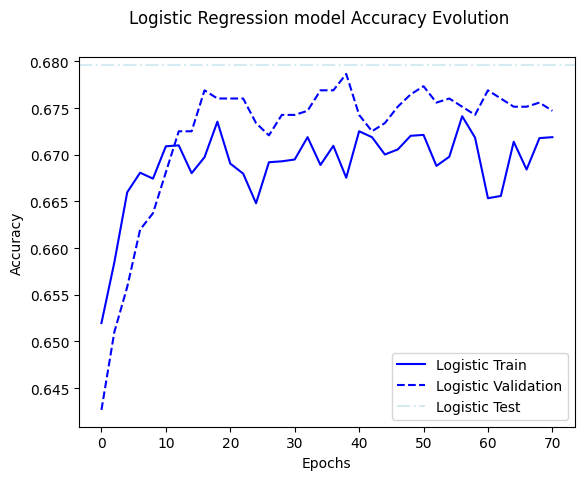

In [131]:
# Plot the evolution during training
plt.plot(log_epochs, log_train_accuracies, label='Logistic Train', linestyle='-', color='blue')
plt.plot(log_epochs, log_val_accuracies, label='Logistic Validation', linestyle='--', color='blue')
plt.axhline(y=logistic_accuracy_test, label='Logistic Test', linestyle='-.', color='lightblue', alpha=0.5)
plt.suptitle('Logistic Regression model Accuracy Evolution')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

- **What do you think of these results?**

We can see that the model is not too bad, but there is room for improvement. The test accuracy is 0.68, which is better than random selection. The training stopped because the accuracy did not improve enough. The difference between validation and training accuracy is unusual, as the validation accuracy is higher than the training accuracy—typically, it is the other way around. This suggests that the model may not be learning effectively. Since this is not a strong model, I will try the others.

### 5.1.4. MLP classifier: define the model

In [141]:
class MLP(nn.Module):
    """
    A Multi-Layer Perceptron (MLP) model implemented as a PyTorch neural network for text classification.

    This model uses pre-trained embeddings and applies mean pooling on the embeddings of the input text.
    It consists of one or more hidden layers with ReLU activation and dropout for regularization,
    followed by an output layer for classification.

    Attributes:
        embedding (nn.Embedding): An embedding layer initialized with pre-trained weights.
        hidden_layers (nn.ModuleList): A list of hidden layers, each followed by ReLU activation and Dropout.
        output_layer (nn.Linear): A linear layer for classification.

    Args:
        embedding_weights (torch.Tensor): Pre-trained word embeddings.
        hidden_dims (List[int]): A list specifying the number of neurons in each hidden layer.
        dropout (float): Dropout rate for regularization.
    """

    def __init__(self, embedding_weights: torch.Tensor, hidden_dims: List[int], dropout: float):
        """
        Initializes the MLP model with given embedding weights, hidden layer dimensions, and dropout rate.

        Args:
            embedding_weights (torch.Tensor): The pre-trained embedding weights to be used in the embedding layer.
            hidden_dims (List[int]): The list of hidden layer sizes.
            dropout (float): The dropout rate to be used for regularization.
        """
        super(MLP, self).__init__()
        # TODO: Determine the embedding dimension from the embedding weights
        embedding_dim: int = embedding_weights.shape[1]

        # TODO: Create an embedding layer with the given pre-trained weights, use the Embedding.from_pretrained function
        self.embedding: nn.Embedding = nn.Embedding.from_pretrained(embedding_weights, freeze=True)

        # TODO: Create hidden layers
        layers: list = list()
        input_dim: int = embedding_dim

        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            input_dim = hidden_dim

        self.hidden_layers: nn.ModuleList = nn.ModuleList(layers)

        # TODO: Create an output layer for classification
        self.output_layer: nn.Linear = nn.Linear(input_dim, 1)

    def forward(self, x: torch.Tensor, text_len: torch.Tensor) -> torch.Tensor:
        """
        Defines the forward pass of the MLP model.

        Args:
            x (torch.Tensor): The input tensor containing word indices.
            text_len (torch.Tensor): Tensor containing the lengths of texts in the batch.

        Returns:
            torch.Tensor: The output tensor after passing through the model.
        """
        # TODO: Embed the input text using the embedding layer
        embedded_x: torch.Tensor = self.embedding(x)

        # TODO: Apply mean pooling to the embedded text
        mask: torch.Tensor = (x != 0).float().unsqueeze(-1)  
        embedded_sum: torch.Tensor = torch.sum(embedded_x * mask, dim=1) 
        x : torch.Tensor = embedded_sum / text_len.unsqueeze(1)

        # TODO: Pass the data through each hidden layer
        for layer in self.hidden_layers:
            x: torch.Tensor = layer(x)

        # TODO: Return the final output after passing it through the output layer
        return self.output_layer(x).squeeze(1)

### 5.1.5. MLP classifier: load the data

In [142]:
# TODO: Define configuration for MLP Classifier training
batch_size: int = 64
epochs: int = 150
print_every: int = 3
patience: int = 15
learning_rate: float = 0.001
hidden_dims: List[int] = [128,64,128,32]

# TODO: Check if GPU is available and move the model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# TODO: Create data loaders with specified batch_size, shuffle the training dataloader
mlp_train_dataloader: DataLoader = DataLoader(tr_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
mlp_val_dataloader: DataLoader = DataLoader(vl_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
mlp_test_dataloader:  DataLoader = DataLoader(ts_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

In [144]:
# TODO: Instantiate the MLP classifier model
mlp_model: MLP = MLP(embedding_weights, hidden_dims, dropout=0.5).to(device)

In [ ]:
# TODO: Define suitable loss criterion and optimizer
mlp_criterion = torch.nn.BCEWithLogitsLoss()
mlp_optimizer: optim = optim.Adam(mlp_model.parameters(), lr=learning_rate, weight_decay=0.0001)

### 5.1.6. MLP classifier: train the model and plot the accuracies

In [146]:
# TODO: Train MLP classifier model
mlp_train_accuracies, mlp_val_accuracies = train_torch_model(mlp_model, mlp_train_dataloader,
                                                             mlp_val_dataloader, mlp_criterion,
                                                             mlp_optimizer, epochs, print_every,
                                                             patience=patience, device=device)

Epoch 1/150
Train Loss: 0.6345, Val Loss: 0.5741
Train Accuracy: 0.6442, Val Accuracy: 0.6901
--------------------------------------------------

Epoch 4/150
Train Loss: 0.5243, Val Loss: 0.5133
Train Accuracy: 0.7265, Val Accuracy: 0.7234
--------------------------------------------------

Epoch 7/150
Train Loss: 0.4942, Val Loss: 0.4874
Train Accuracy: 0.7431, Val Accuracy: 0.7379
--------------------------------------------------

Epoch 10/150
Train Loss: 0.4872, Val Loss: 0.4787
Train Accuracy: 0.7506, Val Accuracy: 0.7410
--------------------------------------------------

Epoch 13/150
Train Loss: 0.4656, Val Loss: 0.4734
Train Accuracy: 0.7580, Val Accuracy: 0.7436
--------------------------------------------------

Epoch 16/150
Train Loss: 0.4655, Val Loss: 0.4787
Train Accuracy: 0.7617, Val Accuracy: 0.7322
--------------------------------------------------

Epoch 19/150
Train Loss: 0.4554, Val Loss: 0.4753
Train Accuracy: 0.7688, Val Accuracy: 0.7467
--------------------------

In [147]:
# TODO: Print accuracy for training, validation and test datasets
mlp_accuracy_train: float = calculate_accuracy(mlp_model,mlp_train_dataloader, device=device)
mlp_accuracy_val: float = calculate_accuracy(mlp_model,mlp_val_dataloader, device=device)
mlp_accuracy_test: float = calculate_accuracy(mlp_model,mlp_test_dataloader, device=device)

print(f"MLP Model - Training Accuracy: {mlp_accuracy_train}")
print(f"MLP Model - Validation Accuracy: {mlp_accuracy_val}")
print(f"MLP Model - Test Accuracy: {mlp_accuracy_test}")

MLP Model - Training Accuracy: 0.8342363449992678
MLP Model - Validation Accuracy: 0.7471466198419666
MLP Model - Test Accuracy: 0.760904044409199


In [148]:
# Obtain epochs where accuracy was calculated in order to plot them
mlp_epochs, mlp_train_accuracies = zip(*sorted(mlp_train_accuracies.items()))
_, mlp_val_accuracies = zip(*sorted(mlp_val_accuracies.items()))

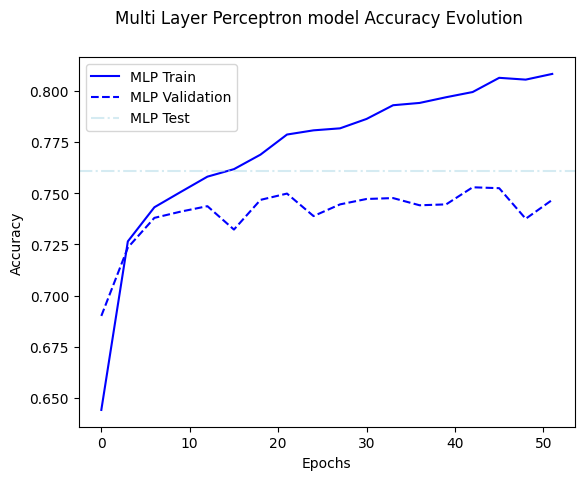

In [149]:
# Plot the evolution during training
plt.plot(mlp_epochs, mlp_train_accuracies, label='MLP Train', linestyle='-', color='blue')
plt.plot(mlp_epochs, mlp_val_accuracies, label='MLP Validation', linestyle='--', color='blue')
plt.axhline(y=mlp_accuracy_test, label='MLP Test', linestyle='-.', color='lightblue', alpha=0.5)
plt.suptitle('Multi Layer Perceptron model Accuracy Evolution')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

- **What do you think of these results?**

 We can see that this model performs slightly better than the previous one, achieving a test accuracy of 0.76—0.08 higher than the Logistic model. This model is not too bad; now, the training accuracy is higher than the validation accuracy, which is a more expected behavior. The training accuracy reaches over 0.85, indicating a tendency to overfit, even though the model includes weight decay and dropout. There is still room for improvement, so let's try another model.

## 5.2. Recurrent models: LSTM Classifier

Before diving into the definition of this model, check this [tutorial](https://gist.github.com/HarshTrivedi/f4e7293e941b17d19058f6fb90ab0fec) and make sure you understand all the steps there. You will have to use the [pack_padded_sequence](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html) in order to be able to handle the padded embeddings.


### 5.2.1 Define the model


In [150]:
class RNN(nn.Module):
    """
    A Recurrent Neural Network (RNN) model implemented using PyTorch for text classification.

    This model utilizes an embedding layer with pre-trained weights, followed by an LSTM layer
    for processing sequential data, and a linear layer for classification.

    Attributes:
        embedding (nn.Embedding): Embedding layer initialized with pre-trained weights.
        rnn (nn.LSTM): LSTM (Long Short Term Memory) layer for processing sequential data.
        fc (nn.Linear): Linear layer for classification.

    Args:
        embedding_weights (torch.Tensor): Pre-trained word embeddings.
        hidden_dim (int): The number of features in the hidden state of the LSTM.
        num_layers (int): The number of layers in the LSTM.
    """

    def __init__(self, embedding_weights: torch.Tensor, hidden_dim: int, num_layers: int):
        """
        Initializes the RNN model with given embedding weights, hidden dimension, and number of layers.

        Args:
            embedding_weights (torch.Tensor): The pre-trained embedding weights to be used in the embedding layer.
            hidden_dim (int): The size of the hidden state in the LSTM layer.
            num_layers (int): The number of layers in the LSTM.
        """
        super().__init__()
        # TODO: Determine the embedding dimension from the embedding weights
        embedding_dim: int = embedding_weights.shape[1]

        # TODO: Create an embedding layer with the given pre-trained weights, use the Embedding.from_pretrained function
        self.embedding: nn.Embedding = nn.Embedding.from_pretrained(embedding_weights, freeze=True)

        # TODO: Initialize the LSTM layer
        self.rnn: nn.LSTM = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True,bidirectional=True)

        # TODO: Create a linear layer for classification
        self.fc: nn.Linear = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x: torch.Tensor, text_lengths: torch.Tensor) -> torch.Tensor:
        """
        Defines the forward pass of the RNN model.

        Args:
            x (torch.Tensor): The input tensor containing word indices.
            text_lengths (torch.Tensor): Tensor containing the lengths of texts in the batch.

        Returns:
            torch.Tensor: The output tensor after passing through the model.
        """
        # TODO: Embed the input text using the embedding layer
        embedded: torch.Tensor = self.embedding(x)

        # TODO: Pack the embedded text for efficient processing in the LSTM
        packed_embedded: torch.Tensor = torch.nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, batch_first=True, enforce_sorted=False)

        # TODO: Pass the packed sequence through the LSTM
        packed_output, (hidden, cell) = self.rnn(packed_embedded)

        # TODO: Use the last hidden state for classification
        hidden_forward: torch.Tensor = hidden[-2]  # Última capa, dirección forward
        hidden_backward: torch.Tensor = hidden[-1]  # Última capa, dirección backward
        hidden: torch.Tensor = torch.cat((hidden_forward, hidden_backward), dim=1)  

        # TODO: Return the final output after passing it through the linear layer
        return self.fc(hidden).squeeze(1)

### 5.2.2 Load the data

In [151]:
# TODO: Define configuration for MLP Classifier training
batch_size: int = 64
epochs: int = 150
print_every: int = 5
patience: int = 15
learning_rate: float = 0.001
hidden_dim: int = 35
num_layers: int = 2

# TODO: Check if GPU is available and move the model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# TODO: Create data loaders with specified batch_size, shuffle the training dataloader
rnn_train_dataloader: DataLoader = DataLoader(tr_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
rnn_val_dataloader: DataLoader = DataLoader(vl_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
rnn_test_dataloader: DataLoader = DataLoader(ts_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

In [153]:
# TODO: Instantiate the RNN classifier model
rnn_model: RNN = RNN(embedding_weights, hidden_dim, num_layers)

In [ ]:
# TODO: Define suitable loss criterion and optimizer
rnn_criterion = torch.nn.BCEWithLogitsLoss()
rnn_optimizer: optim = optim.Adam(rnn_model.parameters(), lr=learning_rate, weight_decay=0.0001)

### 5.2.3 Train the model and plot the accuracies

In [156]:
# TODO: Train RNN classifier model
rnn_train_accuracies, rnn_val_accuracies = train_torch_model(rnn_model, rnn_train_dataloader,
                                                             rnn_val_dataloader, rnn_criterion,
                                                             rnn_optimizer, epochs, print_every,
                                                             patience=patience, device=device)

Epoch 1/150
Train Loss: 0.5398, Val Loss: 0.5062
Train Accuracy: 0.6986, Val Accuracy: 0.6997
--------------------------------------------------

Epoch 6/150
Train Loss: 0.4181, Val Loss: 0.4498
Train Accuracy: 0.7850, Val Accuracy: 0.7467
--------------------------------------------------

Epoch 11/150
Train Loss: 0.3639, Val Loss: 0.4729
Train Accuracy: 0.8249, Val Accuracy: 0.7493
--------------------------------------------------

Epoch 16/150
Train Loss: 0.3070, Val Loss: 0.5274
Train Accuracy: 0.8596, Val Accuracy: 0.7406
--------------------------------------------------

Epoch 21/150
Train Loss: 0.2398, Val Loss: 0.6611
Train Accuracy: 0.8990, Val Accuracy: 0.7450
--------------------------------------------------

Early stopping at epoch 20


In [157]:
# TODO: Print accuracy for training, validation and test datasets
rnn_accuracy_train: float = calculate_accuracy(rnn_model,rnn_train_dataloader, device=device)
rnn_accuracy_val: float = calculate_accuracy(rnn_model,rnn_val_dataloader, device=device)
rnn_accuracy_test: float = calculate_accuracy(rnn_model,rnn_test_dataloader, device=device)

print(f"RNN Model - Training Accuracy: {rnn_accuracy_train}")
print(f"RNN Model - Validation Accuracy: {rnn_accuracy_val}")
print(f"RNN Model - Test Accuracy: {rnn_accuracy_test}")

RNN Model - Training Accuracy: 0.9193634988041197
RNN Model - Validation Accuracy: 0.7445127304653204
RNN Model - Test Accuracy: 0.7513877874702617


In [158]:
# Obtain epochs where accuracy was calculated in order to plot them
rnn_epochs, rnn_train_accuracies = zip(*sorted(rnn_train_accuracies.items()))
_, rnn_val_accuracies = zip(*sorted(rnn_val_accuracies.items()))

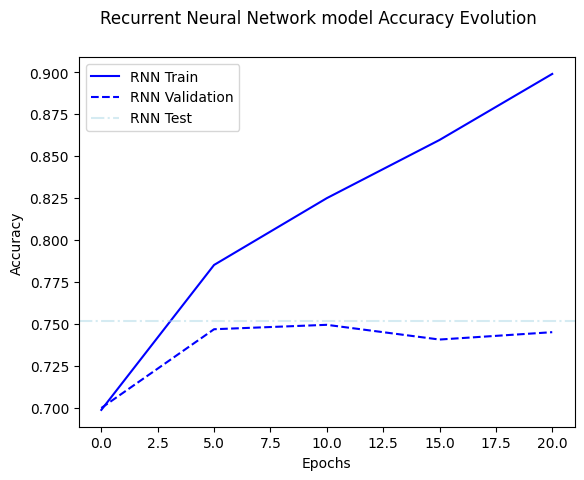

In [159]:
# Plot the evolution during training
plt.plot(rnn_epochs, rnn_train_accuracies, label='RNN Train', linestyle='-', color='blue')
plt.plot(rnn_epochs, rnn_val_accuracies, label='RNN Validation', linestyle='--', color='blue')
plt.axhline(y=rnn_accuracy_test, label='RNN Test', linestyle='-.', color='lightblue', alpha=0.5)
plt.suptitle('Recurrent Neural Network model Accuracy Evolution')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

- **What do you think of these results?**

 I can see that the results of this model are very similar to those of the MLP model, with both achieving a test accuracy of around 0.76. However, this model tends to overfit more than the MLP model, as its training accuracy exceeds 0.9. This model is a bidirectional RNN, a highly complex architecture that learns parameters very quickly—overfitting occurs as early as epoch 20. While it is not a bad model, if I had to choose, I would select the MLP model because the final accuracy is nearly the same, but the RNN model is slower and overfits earlier.

# 6 Conclusions


As we reach the end of our assignments, it's important to reflect on what we've learned and how we can apply this knowledge moving forward. In this section, please provide your conclusions about the assignments you've worked on. Specifically, consider the following points in your write-up:

- **Key Learnings**: Summarize your major learnings from the assignments. What concepts and techniques stood out to you, and why?

In this assigment I have learned a lot of things:

1. I have learned that pre-trained embeddings exist and can be used to reduce computation time while leveraging well-trained embeddings in a very simple way.

2. This assignment allowed me to put into practice the concepts learned in class, particularly regarding different models. In class, we studied RNN models, and now I had the opportunity to experiment with them, comparing bidirectional and standard RNNs and analyzing their differences. It is really helpful to visually confirm that what we learn in theory can be applied to real tasks, such as analyzing tweets.

3. In deep learning, we usually work with very large models that limit our ability to experiment with hyperparameters. However, these smaller models, with shorter execution times, have allowed me to test different hyperparameter values. For example, I explored the effect of weight decay (which needs to be very small) and the size of hidden layers in RNNs.

4. Finally, I have learned small but useful coding tips, such as using functions in the DataLoader (e.g., collate_fn). Additionally, I learned that we cannot use padding indexes (zeros) when training, which is an important consideration for handling sequence data properly...

- **Model Interpretation**: Discuss how you interpret the results from the models you've developed. What do these results suggest about the nature of the data and the effectiveness of the models?

As we saw earlier, the three models were trained to determine whether a tweet was written by a human or a bot.

First, with the Logistic Regression model, we observed that the test accuracy only reached 0.67. This is because it is a very simple model that learns patterns but is not well-suited for this task.

Later, with the MLP and RNN models, we saw an improvement, achieving a test accuracy of around 0.76. These models are slightly more complex, allowing them to learn more intricate patterns for tweet classification. However, they are not perfect; their accuracy is still not high enough, and they tend to overfit as the number of epochs increases. Nonetheless, for a small-scale task like this, they can be used for tweet classification, keeping in mind that the accuracy is not perfect.

All these observations lead me to believe that the nature of the data is the main limiting factor for the models. Despite being good models, they do not achieve the expected accuracy. Perhaps some tweets were generated by highly advanced algorithms, making it more difficult to distinguish between human-written and bot-generated content.

- **Characterizing Tweets**: Reflect on how the models can be used to understand what characterizes bot vs human tweets. How can we obtain information from the models in order to characterize the tweets?

Having in mind that bot tweets are labeled as 1 and human tweets as 0, we can analyze how these models work to distinguish between them:

- Logistic Regression Model: Since bot tweets have label 1 and human tweets 0, this model adjusts the weights during training to assign negative weights to human tweets and positive weights to bot tweets. When a new tweet is processed, these weights help classify it as either human or bot, based on the embeddings of the words that make up the sentence. In essence, the model learns which words or patterns are more indicative of bot-generated content. By examining the learned weights, we can identify which words are strong indicators of bot-generated or human-written tweets. Words with high positive weights likely appear more frequently in bot tweets, while those with negative weights are more associated with human-written content.

- MLP Model: his model, which is a neural network with multiple layers, works by identifying patterns in the data through activation of different layers. Depending on the type of tweet being processed, different neurons are activated, allowing the model to capture more complex relationships between words. This makes it more flexible than logistic regression, as it can learn non-linear patterns that may characterize bot-generated tweets. By analyzing which neurons activate for bot vs. human tweets, we can uncover deeper linguistic patterns. For example, bot-generated tweets might trigger stronger activations in neurons that detect repetitive structures or overuse of certain keywords.

- RNN model: In my case, I used a bidirectional RNN because, as we discussed in class, if a sentence is very long, the final hidden state of a unidirectional RNN might lose information from the beginning of the sentence. A bidirectional RNN processes the tweet in both directions, allowing it to retain more context from the entire sentence. This model processes sentences word by word, making it slower to train. However, it is particularly useful for detecting repetition patterns and analyzing how words influence each other in a sequence, which can be crucial for distinguishing between human and bot-generated text.


# 7 Future Developments
Looking ahead, consider the potential future developments of your models:

- **Improvements and Enhancements**: What improvements or enhancements would you suggest for the models? This could include data processing, feature engineering, model architecture changes, or any other aspect you think could boost performance.

There are several improvements and enhancements that could be made to improve the performance of the models:

Data Processing enhancements:

- Data Processing: Cleaning the text more effectively by removing unnecessary symbols, URLs, and stopwords could help reduce noise. Making the function of tokenization better, using python libreries...

- I do not know if the dataset is balanced or imbalance, but it is important that the number of bot tweets is similar to the number of human tweets to avoid imbalance dataset which could lead to a bad training model.

- Augmenting the Dataset: Generating synthetic data using techniques like back-translation or paraphrasing could provide more training examples and improve generalization.

Feature Engineering Improvements

- Sentiment analysis features to help distinguish human-like emotional tone from bot-generated text.

Model Architecture Enhancements:

- Combining different architectures, such as using CNNs to extract local word patterns along with RNNs for sequence learning, could boost performance.

- Instead of using traditional RNNs, switching to more advanced architectures Transformers models mentioned in class, which capture deeper contextual relationships, could significantly enhance classification performance.

- **Applications and Implications**: Discuss possible future applications of your models. How might these models be used in real-world scenarios? Are there any ethical considerations or potential impacts that should be taken into account?

The models developed for distinguishing between bot and human tweets have several real world applications:

- Social Media: These models can help identify and filter bot-generated misinformation, spam, or harmful content on platforms. Social media companies can use them to reduce the spread of fake news and improve content moderation.

- Colleges/Universities: These models can be used to analyze whether a student's work has been completed using artificial intelligence or their own knowledge, helping to maintain academic integrity and prevent plagiarism.

- Cibersecurity: Bots are often used in phishing attacks, scam promotions, and automated fraud. These models could assist in detecting and flagging suspicious accounts, helping to prevent scams and enhance online security.

There are ethical considerations or potential impacts that should be taken into account: 

- Privacy and Data Bias: Training these models requires large datasets, which may contain biases. If the dataset is skewed toward detecting certain language styles or topics, it could lead to false positives, misclassifying real human users as bots. Additionally, the use of public tweets for training must be handled carefully to respect user privacy and prevent data misuse.

- Adversarial Attacks: If malicious actors understand how these models work, they might design bots that use more natural language patterns, making detection harder.